In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512 * block.expansion, 64)
        self.fc2 = nn.Linear(64, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model



def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model



def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model



def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model



def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [3]:
class CustomDataset(Dataset):
    def __init__(self, img_path_file, label_file, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_file = img_path_file
        self.label_file = label_file

    def __getitem__(self, index):
        image = self.img_path_file[index]
        # Get image data
        
        if self.train_mode:
            label = self.label_file[index]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_path_file)

train_img = torch.load('./trainaugimg.pt')
train_lbl = torch.load('./trainauglabel.pt')
valid_img = torch.load('./validaugimg.pt')
valid_lbl = torch.load('./validauglabel.pt')

In [37]:
train_img = torch.load('./train_gray_img.pt')
# train_img = torch.load('./train_aug_gray_img.pt')
train_lbl = torch.load('./train_original_label.pt')
# train_lbl = torch.load('./trainauglabel.pt')
valid_img = torch.load('./valid_gray_img.pt')
# valid_img = torch.load('./valid_aug_gray_img.pt')
valid_lbl = torch.load('./valid_original_label.pt')
# valid_lbl = torch.load('./validauglabel.pt')
test_img = torch.load('./test_gray_img.pt')

test_img = torch.load('./testimg.pt')

In [38]:
train_img = train_img.unsqueeze(1)
valid_img = valid_img.unsqueeze(1)
test_img = test_img.unsqueeze(1)

In [39]:
CFG = {
    'IMG_SIZE':128,
    'EPOCHS':100,
    'LEARNING_RATE':2e-3,
    'BATCH_SIZE':32,
    'SEED':41
}

In [61]:
train_dataset = CustomDataset(train_img, train_lbl, train_mode=True)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
valid_dataset = CustomDataset(valid_img, valid_lbl, train_mode=True)
valid_loader = DataLoader(valid_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# train_img
# train_lbl
# valid_img
# valid_lbl


In [45]:
import time
def train(model, optimizer, train_loader, vali_loader, scheduler, device):
    model.to(device)

    # Loss Function
    criterion = nn.L1Loss().to(device)
    best_mae = 9999
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            logit = model(img)
            # Calc loss
            loss = criterion(logit.squeeze(1), label)

            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        if scheduler is not None:
            scheduler.step()
            
        # Evaluation Validation set
        vali_mae = validation(model, vali_loader, criterion, device)
        
        print(f'Epoch [{epoch}] Train MAE : [{np.mean(train_loss):.5f}] Validation MAE : [{vali_mae:.5f}]\n')
        
        # Model Saved
        if best_mae > vali_mae:
            best_mae = vali_mae
            torch.save(model.state_dict(), f'./saved/best_model_{time.time()}.pth')
            print('Model Saved.')

In [46]:
def validation(model, vali_loader, criterion, device):
    model.eval() # Evaluation
    vali_loss = []
    with torch.no_grad():
        # meta_loader = [i for i in enumerate(vali_loader)]
        for idx, data in enumerate(vali_loader):
            img, label = data[0], data[1]
            # meta = val_meta_loader[idx]
            # meta = meta_loader[idx][1]
            img, label = img.float().to(device), label.float().to(device)
            # meta = meta.float().to(device)
            
            
            logit = model(img)
            loss = criterion(logit.squeeze(1), label)
            
            vali_loss.append(loss.item())

    vali_mae_loss = np.mean(vali_loss)
    return vali_mae_loss

In [47]:
model = resnet18().to(device)

optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train(model, optimizer, train_loader, valid_loader, scheduler, device)

100%|██████████| 38/38 [00:01<00:00, 22.51it/s]


Epoch [1] Train MAE : [29.31408] Validation MAE : [31.58161]

Model Saved.


100%|██████████| 38/38 [00:01<00:00, 22.97it/s]


Epoch [2] Train MAE : [17.74062] Validation MAE : [16.21506]

Model Saved.


100%|██████████| 38/38 [00:01<00:00, 22.96it/s]


Epoch [3] Train MAE : [17.75848] Validation MAE : [39.14378]



100%|██████████| 38/38 [00:01<00:00, 22.71it/s]


Epoch [4] Train MAE : [16.45419] Validation MAE : [15.27663]

Model Saved.


100%|██████████| 38/38 [00:01<00:00, 21.94it/s]


Epoch [5] Train MAE : [17.84027] Validation MAE : [20.64670]



100%|██████████| 38/38 [00:01<00:00, 22.45it/s]


Epoch [6] Train MAE : [15.49785] Validation MAE : [16.70839]



100%|██████████| 38/38 [00:01<00:00, 22.41it/s]


Epoch [7] Train MAE : [17.12067] Validation MAE : [21.38246]



100%|██████████| 38/38 [00:01<00:00, 22.25it/s]


Epoch [8] Train MAE : [14.69234] Validation MAE : [14.47507]

Model Saved.


100%|██████████| 38/38 [00:01<00:00, 22.14it/s]


Epoch [9] Train MAE : [13.15075] Validation MAE : [18.82133]



100%|██████████| 38/38 [00:01<00:00, 21.96it/s]


Epoch [10] Train MAE : [13.60906] Validation MAE : [15.11245]



100%|██████████| 38/38 [00:01<00:00, 22.14it/s]


Epoch [11] Train MAE : [11.98405] Validation MAE : [12.23751]

Model Saved.


100%|██████████| 38/38 [00:01<00:00, 21.95it/s]


Epoch [12] Train MAE : [9.93832] Validation MAE : [22.02574]



100%|██████████| 38/38 [00:01<00:00, 22.20it/s]


Epoch [13] Train MAE : [9.39191] Validation MAE : [17.65474]



100%|██████████| 38/38 [00:01<00:00, 21.95it/s]


Epoch [14] Train MAE : [9.80786] Validation MAE : [17.74203]



100%|██████████| 38/38 [00:01<00:00, 22.03it/s]


Epoch [15] Train MAE : [8.61081] Validation MAE : [31.09378]



100%|██████████| 38/38 [00:01<00:00, 22.02it/s]


Epoch [16] Train MAE : [8.85712] Validation MAE : [18.61936]



100%|██████████| 38/38 [00:01<00:00, 22.12it/s]


Epoch [17] Train MAE : [8.53788] Validation MAE : [19.52549]



100%|██████████| 38/38 [00:01<00:00, 22.49it/s]


Epoch [18] Train MAE : [8.18223] Validation MAE : [11.58908]

Model Saved.


100%|██████████| 38/38 [00:01<00:00, 22.03it/s]


Epoch [19] Train MAE : [8.28407] Validation MAE : [12.66935]



100%|██████████| 38/38 [00:01<00:00, 21.86it/s]


Epoch [20] Train MAE : [7.94018] Validation MAE : [12.15889]



100%|██████████| 38/38 [00:01<00:00, 22.13it/s]


Epoch [21] Train MAE : [7.31336] Validation MAE : [11.74637]



100%|██████████| 38/38 [00:01<00:00, 22.00it/s]


Epoch [22] Train MAE : [7.03531] Validation MAE : [11.75305]



100%|██████████| 38/38 [00:01<00:00, 22.11it/s]


Epoch [23] Train MAE : [7.93579] Validation MAE : [16.17826]



100%|██████████| 38/38 [00:01<00:00, 22.25it/s]


Epoch [24] Train MAE : [6.54976] Validation MAE : [13.01499]



100%|██████████| 38/38 [00:01<00:00, 22.02it/s]


Epoch [25] Train MAE : [5.74322] Validation MAE : [12.41846]



100%|██████████| 38/38 [00:01<00:00, 21.95it/s]


Epoch [26] Train MAE : [6.42815] Validation MAE : [13.09713]



100%|██████████| 38/38 [00:01<00:00, 21.93it/s]


Epoch [27] Train MAE : [5.15700] Validation MAE : [12.57787]



100%|██████████| 38/38 [00:01<00:00, 21.89it/s]


Epoch [28] Train MAE : [6.21182] Validation MAE : [13.02949]



100%|██████████| 38/38 [00:01<00:00, 21.88it/s]


Epoch [29] Train MAE : [5.56368] Validation MAE : [12.07073]



100%|██████████| 38/38 [00:01<00:00, 21.86it/s]


Epoch [30] Train MAE : [5.78391] Validation MAE : [12.16514]



100%|██████████| 38/38 [00:01<00:00, 22.08it/s]


Epoch [31] Train MAE : [5.46098] Validation MAE : [12.51981]



100%|██████████| 38/38 [00:01<00:00, 21.46it/s]


Epoch [32] Train MAE : [5.21703] Validation MAE : [12.84501]



100%|██████████| 38/38 [00:01<00:00, 19.76it/s]


Epoch [33] Train MAE : [4.78386] Validation MAE : [12.32461]



100%|██████████| 38/38 [00:01<00:00, 21.08it/s]


Epoch [34] Train MAE : [5.26474] Validation MAE : [12.85012]



100%|██████████| 38/38 [00:01<00:00, 20.96it/s]


Epoch [35] Train MAE : [4.62389] Validation MAE : [13.01375]



100%|██████████| 38/38 [00:01<00:00, 20.45it/s]


Epoch [36] Train MAE : [4.55836] Validation MAE : [13.40449]



100%|██████████| 38/38 [00:01<00:00, 20.81it/s]


Epoch [37] Train MAE : [4.47412] Validation MAE : [12.58695]



100%|██████████| 38/38 [00:01<00:00, 21.03it/s]


Epoch [38] Train MAE : [4.58037] Validation MAE : [16.33045]



100%|██████████| 38/38 [00:01<00:00, 20.96it/s]


Epoch [39] Train MAE : [5.62826] Validation MAE : [13.79211]



100%|██████████| 38/38 [00:01<00:00, 20.89it/s]


Epoch [40] Train MAE : [4.47916] Validation MAE : [14.32324]



100%|██████████| 38/38 [00:01<00:00, 20.74it/s]


Epoch [41] Train MAE : [4.25224] Validation MAE : [15.32406]



100%|██████████| 38/38 [00:01<00:00, 20.69it/s]


Epoch [42] Train MAE : [3.88756] Validation MAE : [14.13030]



100%|██████████| 38/38 [00:01<00:00, 20.77it/s]


Epoch [43] Train MAE : [3.83226] Validation MAE : [17.66585]



100%|██████████| 38/38 [00:01<00:00, 20.94it/s]


Epoch [44] Train MAE : [3.85113] Validation MAE : [15.25131]



100%|██████████| 38/38 [00:01<00:00, 21.09it/s]


Epoch [45] Train MAE : [4.37508] Validation MAE : [17.83605]



100%|██████████| 38/38 [00:01<00:00, 21.04it/s]


Epoch [46] Train MAE : [3.89731] Validation MAE : [17.16415]



100%|██████████| 38/38 [00:01<00:00, 21.06it/s]


Epoch [47] Train MAE : [3.73612] Validation MAE : [17.23957]



100%|██████████| 38/38 [00:01<00:00, 20.67it/s]


Epoch [48] Train MAE : [3.64805] Validation MAE : [15.78173]



100%|██████████| 38/38 [00:01<00:00, 21.23it/s]


Epoch [49] Train MAE : [4.12272] Validation MAE : [15.93394]



100%|██████████| 38/38 [00:01<00:00, 20.52it/s]


Epoch [50] Train MAE : [3.88109] Validation MAE : [16.67571]



100%|██████████| 38/38 [00:01<00:00, 20.75it/s]


Epoch [51] Train MAE : [3.39992] Validation MAE : [15.59018]



100%|██████████| 38/38 [00:01<00:00, 20.56it/s]


Epoch [52] Train MAE : [3.99874] Validation MAE : [15.38373]



100%|██████████| 38/38 [00:01<00:00, 20.93it/s]


Epoch [53] Train MAE : [3.59878] Validation MAE : [14.71931]



100%|██████████| 38/38 [00:01<00:00, 20.75it/s]


Epoch [54] Train MAE : [3.31719] Validation MAE : [14.49082]



100%|██████████| 38/38 [00:01<00:00, 20.75it/s]


Epoch [55] Train MAE : [3.39375] Validation MAE : [15.17069]



100%|██████████| 38/38 [00:01<00:00, 20.84it/s]


Epoch [56] Train MAE : [3.33387] Validation MAE : [16.59029]



100%|██████████| 38/38 [00:01<00:00, 20.67it/s]


Epoch [57] Train MAE : [3.25681] Validation MAE : [15.86211]



100%|██████████| 38/38 [00:01<00:00, 20.57it/s]


Epoch [58] Train MAE : [3.56699] Validation MAE : [16.05643]



100%|██████████| 38/38 [00:01<00:00, 21.22it/s]


Epoch [59] Train MAE : [3.26247] Validation MAE : [15.61438]



100%|██████████| 38/38 [00:01<00:00, 20.72it/s]


Epoch [60] Train MAE : [4.01820] Validation MAE : [16.75389]



100%|██████████| 38/38 [00:01<00:00, 20.62it/s]


Epoch [61] Train MAE : [2.97327] Validation MAE : [14.95236]



100%|██████████| 38/38 [00:01<00:00, 20.46it/s]


Epoch [62] Train MAE : [3.00335] Validation MAE : [16.35389]



100%|██████████| 38/38 [00:01<00:00, 20.74it/s]


Epoch [63] Train MAE : [3.22410] Validation MAE : [15.71736]



100%|██████████| 38/38 [00:01<00:00, 21.13it/s]


Epoch [64] Train MAE : [3.39610] Validation MAE : [16.17165]



100%|██████████| 38/38 [00:01<00:00, 21.06it/s]


Epoch [65] Train MAE : [3.06493] Validation MAE : [14.85403]



100%|██████████| 38/38 [00:01<00:00, 21.12it/s]


Epoch [66] Train MAE : [3.11876] Validation MAE : [15.31075]



100%|██████████| 38/38 [00:01<00:00, 20.90it/s]


Epoch [67] Train MAE : [3.02983] Validation MAE : [15.91550]



100%|██████████| 38/38 [00:01<00:00, 20.93it/s]


Epoch [68] Train MAE : [2.97978] Validation MAE : [15.01347]



100%|██████████| 38/38 [00:01<00:00, 20.71it/s]


Epoch [69] Train MAE : [3.62508] Validation MAE : [14.94371]



100%|██████████| 38/38 [00:01<00:00, 20.84it/s]


Epoch [70] Train MAE : [2.75193] Validation MAE : [16.34996]



100%|██████████| 38/38 [00:01<00:00, 21.08it/s]


Epoch [71] Train MAE : [2.82431] Validation MAE : [14.77128]



100%|██████████| 38/38 [00:01<00:00, 21.22it/s]


Epoch [72] Train MAE : [3.05072] Validation MAE : [16.33322]



100%|██████████| 38/38 [00:01<00:00, 21.35it/s]


Epoch [73] Train MAE : [2.85714] Validation MAE : [14.99871]



100%|██████████| 38/38 [00:01<00:00, 21.40it/s]


Epoch [74] Train MAE : [3.13612] Validation MAE : [15.43202]



100%|██████████| 38/38 [00:01<00:00, 21.84it/s]


Epoch [75] Train MAE : [2.78409] Validation MAE : [14.87315]



100%|██████████| 38/38 [00:01<00:00, 21.54it/s]


Epoch [76] Train MAE : [3.15019] Validation MAE : [15.15403]



100%|██████████| 38/38 [00:01<00:00, 21.70it/s]


Epoch [77] Train MAE : [3.68366] Validation MAE : [14.70254]



100%|██████████| 38/38 [00:01<00:00, 21.60it/s]


Epoch [78] Train MAE : [3.15548] Validation MAE : [15.38224]



100%|██████████| 38/38 [00:01<00:00, 21.11it/s]


Epoch [79] Train MAE : [3.19927] Validation MAE : [15.19210]



100%|██████████| 38/38 [00:01<00:00, 21.60it/s]


Epoch [80] Train MAE : [2.85866] Validation MAE : [15.27844]



100%|██████████| 38/38 [00:01<00:00, 21.34it/s]


Epoch [81] Train MAE : [2.88780] Validation MAE : [15.08554]



100%|██████████| 38/38 [00:01<00:00, 21.10it/s]


Epoch [82] Train MAE : [2.93805] Validation MAE : [15.48776]



100%|██████████| 38/38 [00:01<00:00, 21.42it/s]


Epoch [83] Train MAE : [3.09595] Validation MAE : [15.33353]



100%|██████████| 38/38 [00:01<00:00, 21.15it/s]


Epoch [84] Train MAE : [3.07322] Validation MAE : [15.13517]



100%|██████████| 38/38 [00:01<00:00, 21.53it/s]


Epoch [85] Train MAE : [2.75464] Validation MAE : [15.62061]



100%|██████████| 38/38 [00:01<00:00, 21.32it/s]


Epoch [86] Train MAE : [2.92629] Validation MAE : [15.85815]



100%|██████████| 38/38 [00:01<00:00, 21.49it/s]


Epoch [87] Train MAE : [2.72185] Validation MAE : [15.29452]



100%|██████████| 38/38 [00:01<00:00, 21.27it/s]


Epoch [88] Train MAE : [2.91493] Validation MAE : [16.11574]



100%|██████████| 38/38 [00:01<00:00, 21.42it/s]


Epoch [89] Train MAE : [2.77799] Validation MAE : [15.16044]



100%|██████████| 38/38 [00:01<00:00, 21.08it/s]


Epoch [90] Train MAE : [2.69451] Validation MAE : [14.82937]



100%|██████████| 38/38 [00:01<00:00, 21.57it/s]


Epoch [91] Train MAE : [2.65466] Validation MAE : [15.14589]



100%|██████████| 38/38 [00:01<00:00, 21.15it/s]


Epoch [92] Train MAE : [2.79277] Validation MAE : [15.50906]



100%|██████████| 38/38 [00:01<00:00, 21.42it/s]


Epoch [93] Train MAE : [2.92539] Validation MAE : [15.60519]



100%|██████████| 38/38 [00:01<00:00, 21.30it/s]


Epoch [94] Train MAE : [2.79057] Validation MAE : [15.05096]



100%|██████████| 38/38 [00:01<00:00, 21.43it/s]


Epoch [95] Train MAE : [2.88484] Validation MAE : [15.18535]



100%|██████████| 38/38 [00:01<00:00, 21.52it/s]


Epoch [96] Train MAE : [2.71994] Validation MAE : [14.33844]



100%|██████████| 38/38 [00:01<00:00, 21.51it/s]


Epoch [97] Train MAE : [2.73818] Validation MAE : [14.79063]



100%|██████████| 38/38 [00:01<00:00, 21.31it/s]


Epoch [98] Train MAE : [2.97507] Validation MAE : [15.91034]



100%|██████████| 38/38 [00:01<00:00, 21.32it/s]


Epoch [99] Train MAE : [2.51463] Validation MAE : [17.01119]



100%|██████████| 38/38 [00:01<00:00, 21.41it/s]


Epoch [100] Train MAE : [3.42216] Validation MAE : [15.81230]



In [16]:
trainlbl = torch.load('trainauglabel.pt')

In [142]:
torch.save(model, './saved/best_model05101600.pth')

In [68]:
best_model = resnet18().to(device)
best_model.parameters = torch.load('./saved/best_model05101600.pth')

In [50]:
test_dataset = CustomDataset(test_img, None, train_mode=False)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [51]:
len(train_img)

1200

In [52]:
len(train_lbl)

1200

In [53]:
test_pred = torch.Tensor(size=(0,1))

In [54]:
for img in test_loader:
    test_pred = torch.cat((test_pred, model(img.to(device)).cpu().detach()))

In [55]:
import pandas as pd 
preds = np.round(test_pred, decimals=3)

In [56]:
submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = preds
submission.to_csv('./submit_2205120155.csv', index=False)

In [64]:
train_pred = torch.Tensor(size=(0,1))
for img,lbl in train_loader:
    train_pred = torch.cat((train_pred, model(img.to(device)).cpu().detach()))
valid_pred = torch.Tensor(size=(0,1))
for img,lbl in valid_loader:
    valid_pred = torch.cat((valid_pred, model(img.to(device)).cpu().detach()))

In [69]:
train_result = pd.concat((pd.DataFrame(train_pred), pd.DataFrame(valid_pred))).reset_index(drop=True)

In [71]:
train_result.to_csv('./train_val_result.csv')

In [57]:
submission

,img_name,leaf_weight
0,001.png,50.738998
1,002.png,309.903015
2,003.png,0.422000
3,004.png,68.832001
4,005.png,76.095001
...,...,...
455,456.png,73.408997
456,457.png,75.888000
457,458.png,34.875999
458,459.png,46.819000


# Get Dataloader
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
for img, lbl in train_loader:
    print(img.shape)
    break
all_meta_path = glob.glob(os.path.join('dataset_128', 'train', 'CASE*', 'meta', '*.csv'))
test_meta_path = glob.glob(os.path.join('dataset_128', 'test', 'meta', '*.csv'))
from sklearn.preprocessing import MinMaxScaler
train_scaler = MinMaxScaler(feature_range=(-1,1))
test_scaler = MinMaxScaler(feature_range=(-1,1))
train_val_meta = [train_scaler.fit_transform(torch.Tensor(pd.read_csv(i)[['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
       '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하',
       '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']].fillna(method='bfill').fillna(0).to_numpy().flatten().astype('float32')).reshape(1,-1)).squeeze(0) for i in all_meta_path]

test_meta = [test_scaler.fit_transform(torch.Tensor(pd.read_csv(i)[['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
       '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하',
       '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']].fillna(method='bfill').fillna(0).to_numpy().flatten().astype('float32')).reshape(1,-1)).squeeze(0) for i in test_meta_path]
train_meta = train_val_meta[:train_len]
val_meta = train_val_meta[train_len:]
train_meta_loader = DataLoader(train_meta, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)     #random seed 고정
val_meta_loader = DataLoader(val_meta, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)     #random seed 고정

test_meta_loader = DataLoader(test_meta, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)     #random seed 고정

In [62]:
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
all_meta_path = glob.glob(os.path.join('dataset_128', 'train', 'CASE*', 'meta', '*.csv'))
all_label = glob.glob(os.path.join('dataset_128', 'train', 'CASE*', '*.csv'))
test_meta_path = glob.glob(os.path.join('dataset_128', 'test', 'meta', '*.csv'))

In [73]:
total_label = pd.DataFrame(columns=['img_name', 'leaf_weight'])
for lbl in all_label:
    total_label = pd.concat((total_label, pd.read_csv(lbl, index_col=0)))

In [86]:
total_label['leaf_weight'].tolist().index(481.375)

114

In [107]:
total_label.iloc[[1300]]

,img_name,leaf_weight
21,CASE61_22.png,94.746


In [114]:
%matplotlib inline
temp = pd.read_csv(all_meta_path[300])

In [115]:
temp

,Unnamed: 0,시간,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
0,0,2021-06-22 16:59,25.5,23.200001,82.500000,58.000000,354.0,0.122802,7670.71,95.0,24.0,30.0,25.0,12.500000,23.0,0.0,380.6497,293.9395,39.7152,46.9950
1,1,2021-06-22 17:00,25.5,23.200001,82.599998,57.299999,354.0,0.000000,7670.71,95.0,24.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2021-06-22 17:01,25.4,23.200001,82.599998,56.400002,353.0,0.000000,7670.71,95.0,24.0,30.0,25.0,11.999998,23.0,0.0,380.6497,293.9395,39.7152,46.9950
3,3,2021-06-22 17:02,25.5,23.100000,82.500000,55.799999,353.0,0.000000,7670.71,95.0,NaN,NaN,25.0,11.999998,23.0,0.0,380.6497,293.9395,39.7152,46.9950
4,4,2021-06-22 17:03,25.5,23.100000,82.500000,54.599998,358.0,0.000000,7670.71,95.0,24.0,30.0,25.0,12.500000,23.0,0.0,380.6497,293.9395,39.7152,46.9950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1435,2021-06-23 16:54,25.5,22.799999,82.599998,56.799999,357.0,0.291460,9579.05,95.0,24.0,31.0,25.0,12.500000,23.0,0.0,382.2162,293.9395,39.7152,48.5615
1436,1436,2021-06-23 16:55,25.5,22.700001,82.500000,55.400002,359.0,0.290683,9579.05,95.0,24.0,30.0,25.0,12.500000,23.0,0.0,380.6497,293.9395,39.7152,46.9950
1437,1437,2021-06-23 16:56,25.4,22.600000,82.400002,55.000000,357.0,0.290683,9579.05,95.0,NaN,30.0,25.0,11.999998,23.0,0.0,380.6497,293.9395,39.7152,46.9950
1438,1438,2021-06-23 16:57,25.5,22.799999,82.400002,56.299999,359.0,0.288351,9579.05,95.0,24.0,30.0,25.0,12.500000,23.0,0.0,380.6497,293.9395,39.7152,46.9950


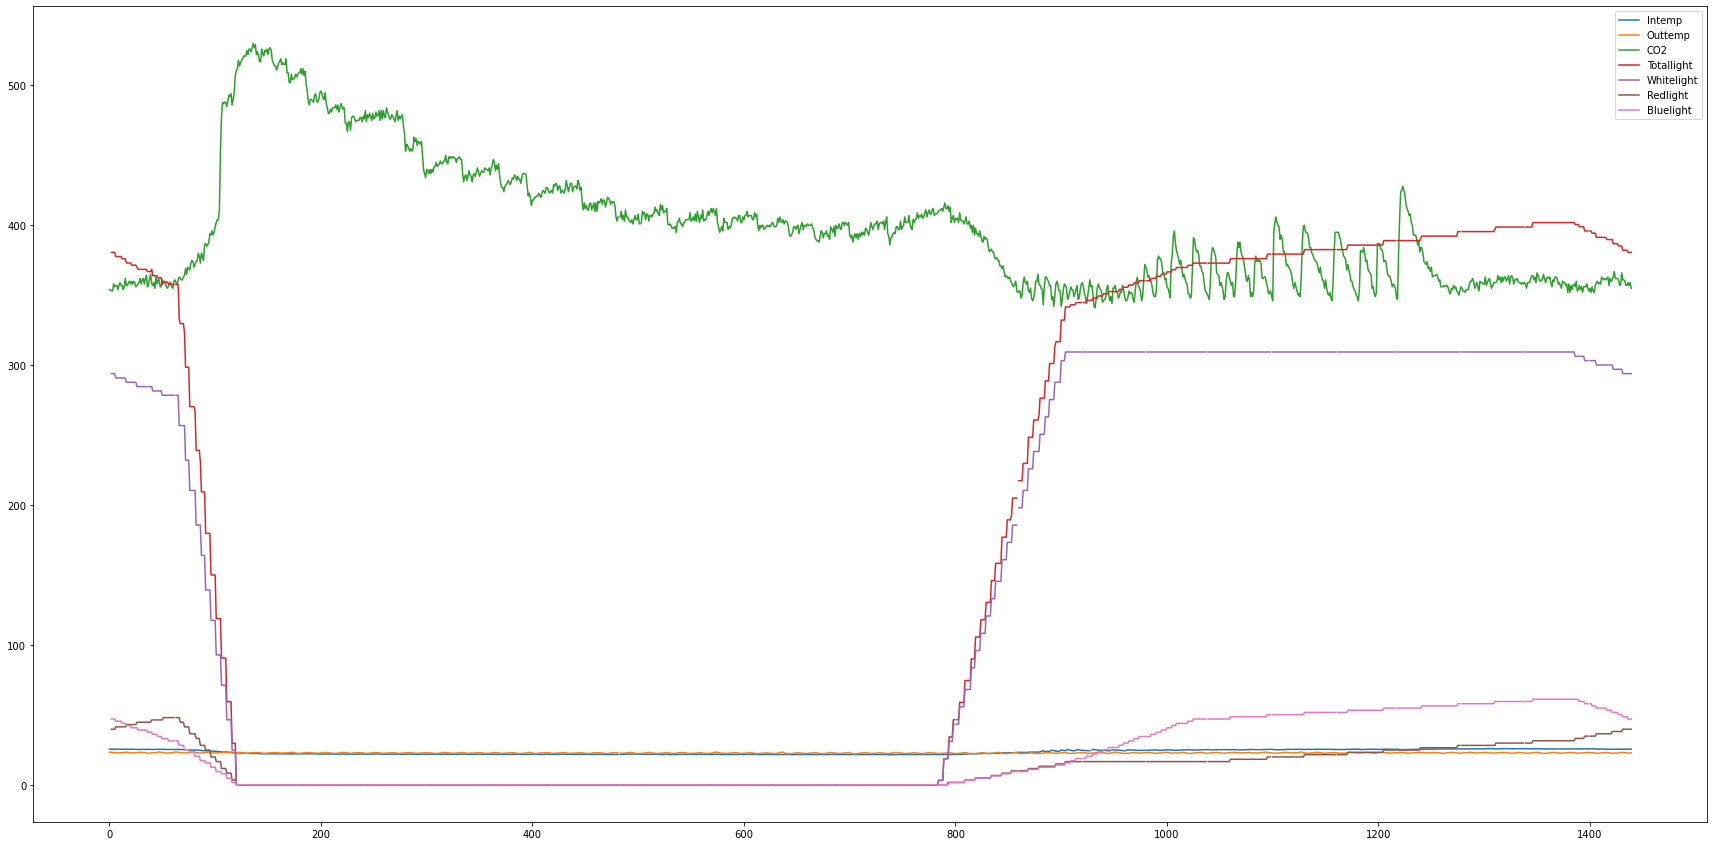

In [116]:
plt.figure(figsize=(30,15))
plt.plot(temp[['내부온도관측치', '외부온도관측치', 'CO2관측치', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']])
plt.legend(['Intemp', 'Outtemp', 'CO2', 'Totallight', 'Whitelight', 'Redlight', 'Bluelight'])
plt.show()

<AxesSubplot:>

d:\Users\DJK-Office\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\DJK-Office\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\DJK-Office\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\DJK-Office\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\DJK-Office\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\DJK-Office\Anaconda3\envs\

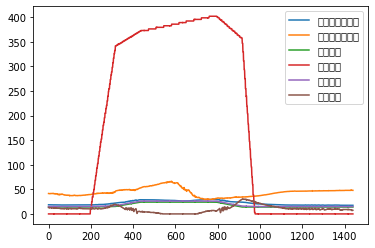

In [32]:
temp[['내부온도관측치', '외부온도관측치','냉방온도', '냉방부하', '난방온도', '난방부하']].plot()
# temp[['내부온도관측치', '외부온도관측치']].plot()